<a href="https://colab.research.google.com/github/vivivicdjdk/machine/blob/main/7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 모델  훈련

**손실 곡선**

노트북의 코드 셸은 print()명령이 없어도 마지막 라인의 실행 결과를 자동으로 출력


```
<tensorflow.python.keras.callbacks.History at 0x7fef38bfc080>
```


즉 위 메시지는 fit()메서드의 실행 결과를 출력한 것. 다시 말해 fit()메서드가 무언가 반환한다는 것을 알려줌

Histoty 클래스의 객체를 반환하는데, 훈련 과정에서 계산한 손실과 정확도 값이 저장되어 있음

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# 모델을 함수로 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # 밀집층 1 Flattem 층
    model.add(keras.layers.Dense(100, activation='relu')) # 밀집층 2 dense 층
    if a_layer: # 모델 추가 가능
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 훈련
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
h = model.fit(train_scaled, train_target, epochs=5, verbose=0)

여기서 verbose는 훈련 과정을 얼마나 자세히 출력할 것인가를 조절함

기본값은 1이며 epoch마다 진행 막대와 함께 손실 등의 지표가 출력

2로 설정하면 진행 막대를 빼고 출력

0으로 설정하면 훈련 과정은 나타나지 않음

In [ ]:
print(h.history.keys())

dict_keys(['loss', 'accuracy'])


history 객체에는 훈련 측정값이 담겨있는 history딕셔너리가 있음

손실(loss)와 정확도(accuracy)가 포함되어 있는데, 케라스는 기본적으로 에포크마다 손실을 계산함

정확도는 compile()메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 포함됨

손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이므로 맷플롯립을 사용해 그래프를 그릴 수 있음

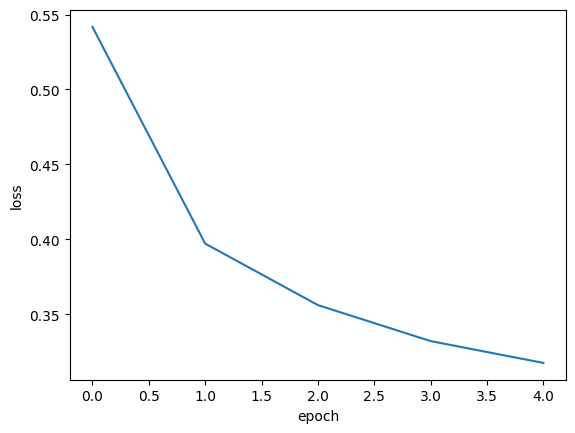

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

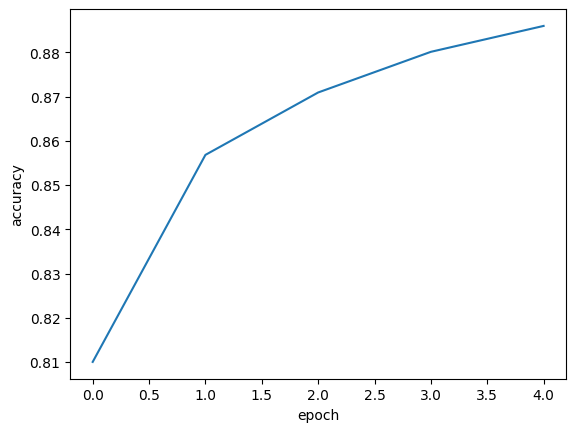

In [ ]:
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크 증가 후 훈련

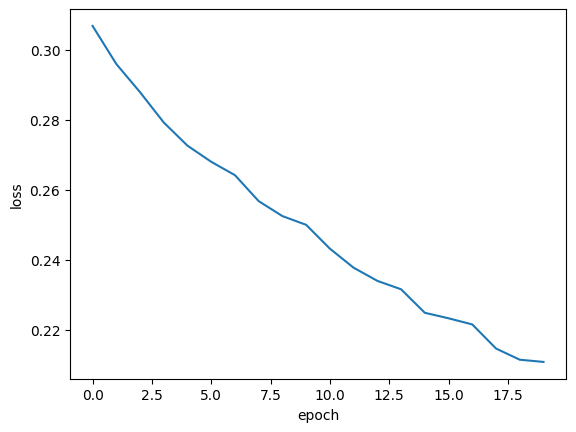

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실이 더 낮아짐

이전보다 더 나은 모델을 훈련한 것인가?

인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 과대/과소적합과 에포크 사이의 관계를 조절해야함

에포크에 따른 과대/과소 적합을 파악하려면 훈련 세트에 대한 점수 뿐만 아니라 검증 세트에 대한 점수도 필요

이를 위해 필요한 것이 **검증 손실**

---

인공 신경망 모델이 최적화하는 대상은 정확도가 아니라 손실 함수

가끔식 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있지만 손실 함수를 기준으로 최적화를 수행

왜 손실 함수를 지표로 삼는가?

예를 들어 100개의 훈련 데이터 중 30개만 올바르게 예측하면 정확도는 30%

이때 가중치 매개변수를 약간 조정한다고 해도 정확도는 그대로 30%로서 약간의 매개변수 조정은 정확도에 의미있는 변화를 주기 힘듬

왜냐하면 30.0003%와 같은 연속적인 값보다는 32%,33%처럼 불연속적인 값으로 표현되기 때문에 정확도에 의미잇는 변화를 주기 위해 가중치 매개변수의 변화 폭이 크거나 훈련 데이터가 많아야 함

반면에 손실함수는 불연속적인 값으로 표현되며 약간의 매개변수 변화로도 값에 변화를 줄 수 있음

---

신경망 학습에서는 최적의 매개변수를 찾는 방법

기울기를 계산하고 이를 기반으로 매개변수의 값르 조금씩 조정하는 과정의 반복

만약 기울기가 0이 되면 현 매개변수가 최적값으로 설정

또는 반복횟수에 제한이 있다면 그 제한안에서 최소의 기울기를 가지는 매개변수를 최적값으로 설정


검증 세트에 대한 손실과 정확도 점수를 구해보자

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


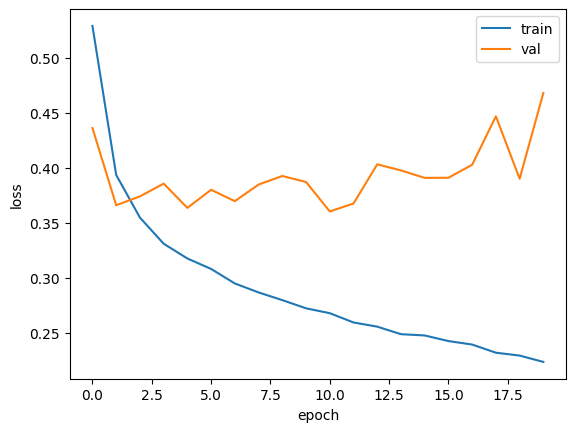

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실은 감소하다가 점점 상승함

훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어짐

검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것

우선 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시켜보자

기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작함

다른 옵티마이저는 Adam이 좋음

Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있음

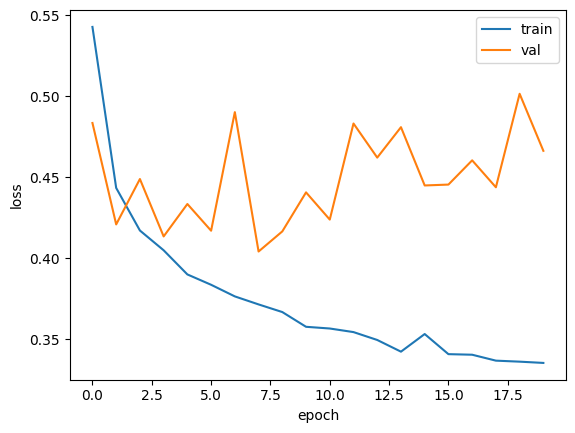

In [ ]:
model = model_fn()
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy') # 문자열
adam_lr = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam_lr, loss='sparse_categorical_crossentropy', metrics='accuracy') # 객체명
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 감소됨

검증 손실 그래프에 여전히 요동이 있지만 16번째 에포크까지는 전반적인 감소 추세가 이어지고 있음

이것은 Adam 옵티마이저가 이 데이터세트에 잘 맞는다는 것을 보여줌

더 나은 손실 곡선을 얻으려면 학습률을 조정해서 시도할 수 있음

**드롭아웃(dropout)**

신경망에서 사용하는 대표적인 규제 방법

훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 (즉 해당 뉴런의 출력을 0으로 만들어) 과대 적합을 막음

반면에 드롭아웃을 하지 않는 뉴런의 출력은 1/(1-r)만큼 증가시켜 출력의 총합이 같도록 함

여기서 r은 드롭할 뉴런의 비율로서 하이퍼파라미터

반면에 검증이나 평가할 때는 모든 뉴런을 사용함

예를 들어,

어떤 샘플을 처리할 때는 은닉층의 n2 번째 뉴런이 드롭아웃되어 h2 출력이 없음

다른 샘플을 처리할 때는 은닉층의 n1 번째 뉴런이 드롭아웃되어 h1 출력이 없음

**드롭아웃이 과대적합을 막을 수 있는 이유(해석)**

1. 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 함. 즉, 일부 뉴런의 출력이 없을 수도 있다는 것을 감안하면 신경망은 더 안정적인 예측을 만들 수 있을 것임.

2. 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블 하는 것처럼 적용될 수 있음

In [ ]:
model = model_fn(keras.layers.Dropout(0.3)) # 드롭아웃을 30%정도 수행
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




```
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28))) # 밀집층 1 Flattem 층
model.add(keras.layers.Dense(100, activation='relu')) # 밀집층 2 dense 층
model.add((keras.layers.Dropout(0.3)))
model.add(keras.layers.Dense(10, activation='softmax'))
```



은닉층 뒤에 추가된 드롭아웃 층은 훈련되는 모델 파라미터가 없고 입력과 출력의 크기가 같음

단지 일부 뉴런의 출력을 0으로 만듦

훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 않아야함

텐서플로와 케라스는 모델을 평가와 예측에 사용될 때는 자동으로 드롭아웃을 적용하지 않음

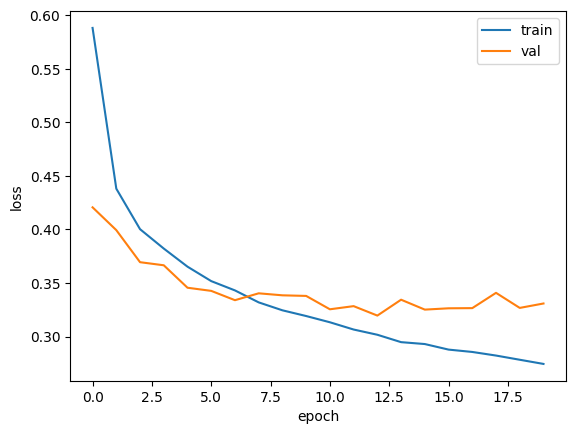

12


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

import numpy as np
min_loss=np.argmin(history.history['val_loss'])
print(min_loss) # 최소의 검증 손실

과대적합 많이 줄어듬

15번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있음

이 모델은 20번의 에포크 동안 훈련을 했기 때문에 다소 과대 적합 되어 있음

**모델 저장과 복원**

만들어진 모델을 나중에 다시 사용하려면 모델을 저장해야함

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드를 제공함


```
model.save_weights('model-wheights.h5')
model.load_weights('model-wheights.h5')
```



* save_weights() 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 확장자가 '.h5'일 경우 HDF5(Hierarchical Data Format) 포멧으로 저장

---

또한 모델 구조와 모델 파라미터를 함께 저장하는 save()메서드도 제공함



```
model.save('model-whole.h5')
model = keras.models.load_model('model-whole.h5')

```


* save() 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 확장자가 '.h5'일 경우 HDF5(Hierarchical Data Format) 포멧으로 저장


In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

model.save_weights('model-weights.h5')
model.save('model-whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


두 파일이 제대로 만들어졌는지 확인

'!'문자로 시작되면 코랩은 이후 명령을 파이썬 코드가 아니라 리눅스 쉘 명령으로 인식

In [ ]:
# -a: 경로 안의 모든 파일과 디렉토리 표시
# -l: 지정한 디렉토리 내용을 자세히 표시
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Nov 14 10:42 model-weights.h5
-rw-r--r-- 1 root root 981176 Nov 14 10:42 model-whole.h5


훈련을 하지 않은 새로운 모델을 만들고 model-weights.h5파일에서 훈련된 모델 파라미터를 읽어서 사용

모델 파라미터만 보관하고 있으므로 저장했던 모델과 정확히 같은 구조를 가져야함

In [ ]:
new_model = model_fn(keras.layers.Dropout(0.3))

new_model.load_weights('model-weights.h5')

**모델의 검증 정확도 확인**

predict()메서드

샘플마다 모든(여기서는 10개) 클래스에 대한 확률을 반환

10개의 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해야 함

In [ ]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.88025


argmax() 함수의 axis=-1은 배열의 마지막 차원을 따라 최대값의 인덱스 선택

2차원이므로 마지막 차원은 1이 되며, 열을 따라 각 행의 최대값의 인덱스를 선택

만약 axis=0 이면, 행을 따라 각 열의 최대값으로 인덱스를 선택

기본값은 None으로 전체 배열에서 최대값을 찾음

evaluate()메서드

손실을 출력하기 위해 compile()메서드를 먼저 실행해야함

fit()메서드는 실행할 필요없음. 이미 훈련한 모델의 파라미터를 불러와서 사용하기 때문

**모델 전체를 파일에서 읽고 모델의 검증 정확도 확인**

keras.models.load_model() 함수는 모델 파라미터 뿐만 아니라 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 compile() 없이

evaluate()를 사용할 수 있음


In [ ]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8802


[0.3311610519886017, 0.8802499771118164]

**콜백(call back)**

위 과정은 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인한 후 과대적합 되지 않는 에포크로 다시 훈련했음

모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수 있는 방법은 콜백을 이용하는 것임

콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로서 keras.callbacks 패키지 아래에 있는 클래스

fit() 메서드의 callbacks 매개변수에 **리스트**로 전달하여 사용

---

ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장

save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음

monitor 매개변수는 모니터링할 지표를 지정함. 기본값은 val_loss로 검증 손실을 관찰함

save_weights_only 매개변수의 기본값은 False로 전체 모델을 저장함. True로 지정하면 모델의 가중치와 절편만 저장

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [ ]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3177 - accuracy: 0.8864


[0.31770583987236023, 0.8864166736602783]

**조기 종료 (early stopping)**

위 모델은 가장 낮은 검증 점수를 가지는 모델을 자동으로 저장해주나 여전히 20번의 에포크 동안 훈련을 해야함

검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없으므로 이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있음

과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 조기 종료라고 하며 딥러닝에서 널리 사용함

조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합되는 것을 막아주기 때문에 규제 방법 중 하나로 생각할 수도 있음

---

케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공함

patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에프크 횟수를 지정할 수 있음

예를 들어, parience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지함

restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

monitor 매개변수는 모니터링할 지표를 지정함. 기본값은 val_loss로 검증 손실을 관찰함

---

EarlyStopping 콜백을 ModelCheckporint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있음

또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌림

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_loss')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
print(early_stopping_cb.stopped_epoch) # 몇 번째 에포크에서 훈련이 중지됐는지 출력

10


13번째 에포크에서 훈련이 중지됨. patience를 2로 지정했으므로 최상의 모델은 11번째 에포크일 것임.

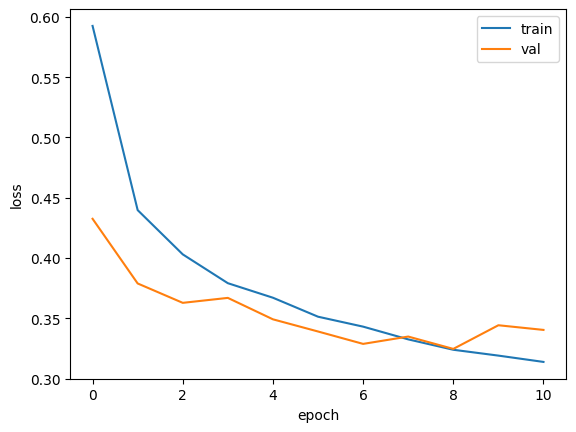

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

검증손실

드롭아웃

모델 저장과 복원

콜백

조기종료

!!!중요!!!